In [2]:
pip install bootstrapped

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from statsmodels.stats.power import GofChisquarePower
from statsmodels.stats.power import TTestPower
from sklearn.model_selection import train_test_split

import pandahouse as ph

import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

# Задание 1. A/B–тестирование
**1.1 Условие**

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**1.2 Входные данные**

В качестве входных данных Вы имеете 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [4]:
# сами файлы не залил, как было указано в задании
try:
    groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/UhyYx41rTt3clQ', sep=';')
except:
    groups = pd.read_csv('2_groups.csv', sep=';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
try:
    groups_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
except:    
    groups_add = pd.read_csv('2_group_add.csv')
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [6]:
active = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/ZAmSh-oO1_ZJjw')
active.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [7]:
checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Fn3ZfSjTrNdzOw', sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [8]:
def shapes(x1, x2, x3, x4):
    print(f'размерность первой:', x1.shape)
    print(f'размерность второй:', x2.shape)
    print(f'размерность третьей:', x3.shape)
    print(f'размерность четвертой:', x4.shape)

In [9]:
shapes(groups, groups_add, active, checks)

размерность первой: (74484, 2)
размерность второй: (92, 2)
размерность третьей: (8341, 1)
размерность четвертой: (541, 2)


## Про метрики и сегментацию
Никаких дополнительных данных по пользователям к сожалению нет (даты покупок, геопренадлежность и другие фичи), поэтому, если будет положительный эффект от изменения механики, то изменения будут для всех сегментов. Смотрим на общую картину.

Из имеющихся данных можно посчитать CR в покупку активных пользователей, ARPAU и ARPPU. Общий CR в покупку считать смысла не вижу ввиду того, что тестируется именно механика оплаты, то есть перед этим пользователь проявил интерес к продукту и хотя бы зашел на платформу.

**По поводу пользоваталей, присланных через 2 дня.**

Так как спросить не у кого, откуда эти пользователи, когда они заходили в приложение и/или совершили покупку, то примем гипотезу о том, что произошла ошибка, и их просто забыли докинуть в основную группу. Но если эти пользователи совершали действия не во время теста, то учитывать их нельзя.

In [10]:
# первым делом я соединю 2 таблицы пользоваталей, для этого надо убедиться, что нет повторяющихся пользователей
id = groups_add["id"].to_list()

In [11]:
groups.query('id == @id')

,id,grp


In [12]:
groups_all = pd.concat([groups, groups_add])

In [13]:
len(groups_all) == (len(groups) + len(groups_add))

True

In [14]:
groups_all.value_counts('grp') # выборки 20/80, что странно

grp
B    59883
A    14693
dtype: int64

In [15]:
59883 / (59883 + 14693)

0.8029795108345849

In [16]:
# также проверим, нет ли пользоваталей A в другой группе и наоборот
groups_all['id'].nunique() == len(groups_all)

True

In [17]:
groups_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [18]:
len(active) == active['student_id'].nunique()

True

In [19]:
checks['student_id'].nunique() # проверили на дубликаты

541

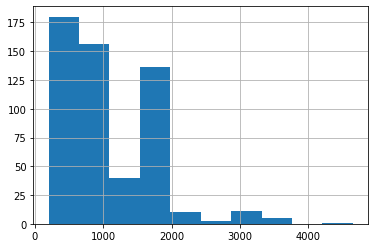

In [20]:
checks['rev'].hist()

In [21]:
# сджойним активных пользоваталей с таблицей групп. Предварительно меняем имена колонок
groups_all.columns = ['student_id', 'group']

In [22]:
active_users = active.merge(groups_all, how='left', on='student_id')

In [23]:
len(active) == len(active_users)

True

In [24]:
# также джойним потраченные деньги
active_users_payments = active_users.merge(checks, how='left', on='student_id')

In [25]:
active_users_payments = active_users_payments.fillna(0)

In [26]:
active_users_payments

,student_id,group,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0
...,...,...,...
8336,1794344,B,0.0
8337,296883,B,0.0
8338,3598448,B,0.0
8339,3610547,B,290.0


## Проверка гипотез
После получения финальной таблицы необходимо проверить различия в двух группах на стат значимость. Для этого есть много критериев, которые будут применимы в зависимости от условий, о чем ниже.
### Сравнение конверсии в покупку двух групп
Для сравнения двух номинативных переменных с 2 градациями подходит критерий Хи Квадрат. 2 группы - A и B, 2 градации - число купивших и тех, кто не купил. Перед началом сравнения надо проверить условия для применения данного критерия.

*Гипотезы: H0 - переменные не связаны между собой, H1 - есть связь между двумя переменными.*

Условиями применения критерия является, чтобы наблюдаемые значения были больше 10 (иначе использутеся поправка Йетса).

Для применения критерия удобно будет сделать колонку со статусом, который бы указывал на то, заплатил ли клиент или нет.  В качестве p-уровня значимости alpha возьмем 0.05.

In [27]:
active_users_payments['status'] = active_users_payments['rev'] > 0

In [28]:
active_users_payments

,student_id,group,rev,status
0,581585,A,0.0,False
1,5723133,A,0.0,False
2,3276743,B,0.0,False
3,4238589,A,0.0,False
4,4475369,B,0.0,False
...,...,...,...,...
8336,1794344,B,0.0,False
8337,296883,B,0.0,False
8338,3598448,B,0.0,False
8339,3610547,B,290.0,True


In [29]:
chi_sq = active_users_payments.groupby('group', as_index=False) \
                            .agg({'rev': 'count', 'status': 'sum'}) \
                            .rename(columns={'rev':'all', 'status': 'payments'})

In [30]:
chi_sq

,group,all,payments
0,A,1538,78
1,B,6803,314


*Можно заметить, что итоговое число платящих пользователей меньше того, что было в чеках, что говорит о том, что некоторые из них не были активными. Скорее всего это связано с автоплатежом, поэтому в тесте они учитываться не будут. Также можно предположить, что возникли ошибки при логировании данных, что желательно как-то проверить.*

In [31]:
b = np.array([[1538, 78], [6803, 314]])
ss.chi2_contingency(b)

(0.43612258061018483,
 0.5089998823014525,
 1,
 array([[1543.46226955,   72.53773045],
        [6797.53773045,  319.46226955]]))

In [32]:
ss.chi2_contingency(b)[1]

0.5089998823014525

In [33]:
78 / 1538 # конверсия для контрольной группы

0.05071521456436931

In [34]:
314 / 6803 # конверсия для испытуемой группы

0.046156107599588415

### Промежуточные выводы по CR активной аудитории в покупку
p-value равен 0.43, что говорит о том, что мы не можем отвергнуть нулевую гипотезу. Однако, чтобы не совершить ошибку второго рода, когда мы отвергаем H1 при том, что она верна, необходимо посчитать мощность теста. В индустрии принято брать мощность теста в 80%, т.е. в 80% процентов случаев при многократном повторении эксперимента мы бы нашли различия в группах. Воспользуемся объектом GofChisquarePower и методом solve_power

In [35]:
# вычислим относительную разницу между конверсиями групп A и B по формуле
p_0 = 78 / 1538
p_1 = 314 / 6803
effect_size = np.sqrt((p_0 - p_1)**2 / p_0)

nobs = 1538 # минимальное значение выборки
alpha = 0.05 

# заносим аргументы, оставляем пустым аругмент, который хотим узнать
power_of_test = GofChisquarePower().solve_power(effect_size = effect_size, 
                                           nobs=nobs, 
                                           alpha=alpha, 
                                           power=None)
print(power_of_test) # мощность теста

0.12474722627935497


In [36]:
# выясним, какой минимальный размер должен быть у выборки с мощностью теста 0.8
p_0 = 78 / 1538
p_1 = 314 / 6803
effect_size = np.sqrt((p_0 - p_1)**2 / p_0)

power = 0.8 # мощность
alpha = 0.05 


size = GofChisquarePower().solve_power(effect_size = effect_size, 
                                           nobs=None, 
                                           alpha=alpha, 
                                           power=power)
print(size)

19150.729178982485


*Исходя из того, что мощность теста Хи-квадрат недостаточна, можно использовать бутстрап для сравнения средних в двух выборках. Для этого надо логические значения перевести в численный вид*

In [37]:
active_users_payments['bin'] = (active_users_payments['rev'] > 0)*1

In [38]:
active_users_payments

,student_id,group,rev,status,bin
0,581585,A,0.0,False,0
1,5723133,A,0.0,False,0
2,3276743,B,0.0,False,0
3,4238589,A,0.0,False,0
4,4475369,B,0.0,False,0
...,...,...,...,...,...
8336,1794344,B,0.0,False,0
8337,296883,B,0.0,False,0
8338,3598448,B,0.0,False,0
8339,3610547,B,290.0,True,1


In [39]:
mean_cr_A = active_users_payments.query('group == "A"')['bin']
mean_cr_B = active_users_payments.query('group == "B"')['bin']

In [40]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрап-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return { 
            "ci": ci, 
            "p_value": p_value}

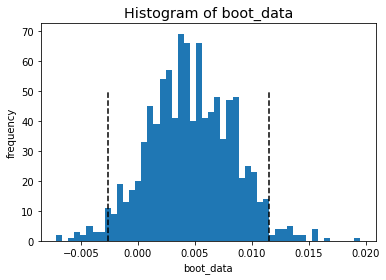

{'ci':               0
 0.025 -0.002646
 0.975  0.011473,
 'p_value': 0.21307302173040388}

In [41]:
get_bootstrap(mean_cr_A, mean_cr_B)

In [42]:
mean_cr_A_arr = np.array(active_users_payments.query('group == "A"')['bin'])
mean_cr_B_arr = np.array(active_users_payments.query('group == "B"')['bin'])

*Значимых отличий тоже обнаружить не удалось*

### Выводы по CR
Как показал тест, вероятность найти различия между группами, если верна H1, очень мала и составляет 12% из-за недостаточности данных. Бутстрап, являясь более мощным тестом, также не показали стат. значимых различий средних в двух группах, что говорит о том, что мы не можем отклонить нулевую гипотезу о том, что конверсия не зависит от группы.

### Проверка ARPAU
Для проверки подходят критерии, где проверяется группы с численными и номинативными переменными - t-тест, ANOVA и их разновидности. Так как группы 2, то ANOVA не применяется. У t-теста есть несколько условий его применения, которые должны соблюдаться:
- гомогенность дисперсий в обеих группах
- не должно быть сильных выбросов в обеих группах, иначе результаты теста могут ввести в заблуждение

Если условия не соблюдаются, то можно сделать:
- использовать тест Уэлча при разных дисперсиях
- прологарифмировать обе выборки и сравнить их
- ипользовать бутстрап и сравнить средние
- использовать бутстрап и сравнить медианы
- использовать непараметрический тест Манна-Уитни и сравнивать ранги, т.е. сами распределения

*Выдвигаемые гипотезы: H0 - разницы между средними чеками в обеих группах нет, H1 - есть отличия между средними чеками в группах* 

alpha=0.05

In [43]:
# ради интереса посмотрим на средний чек
active_users_payments.groupby('group').agg({'rev': 'mean'}).reset_index()

,group,rev
0,A,47.347204
1,B,58.058798


In [44]:
# ради интереса посмотрим на медианный чек
active_users_payments.groupby('group').agg({'rev': 'median'}).reset_index() 

,group,rev
0,A,0.0
1,B,0.0


*Исходя из CR в покупку, очень много нулей в обеих группах, что не позволит сравнить медианы трат.*

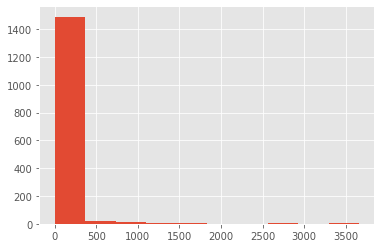

In [45]:
active_users_payments.query('group == "A"')['rev'].hist() # типичные распределения трат

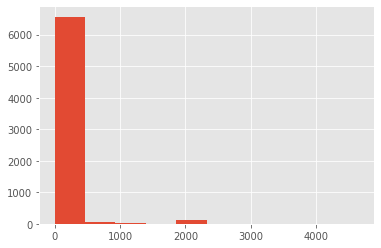

In [46]:
active_users_payments.query('group == "B"')['rev'].hist()

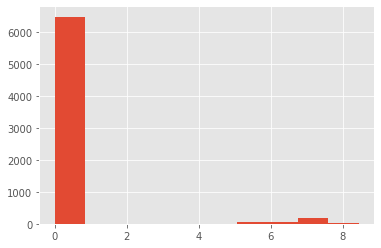

In [47]:
np.log(active_users_payments.query('group == "B"')['rev'] + 1).hist() # полномочия логарифма все

*Выбросы есть в обеих выборках, в испытуемой группе они больше. Построим боксплот для наглядности, а также проверим выборки на равенство дисперсий*

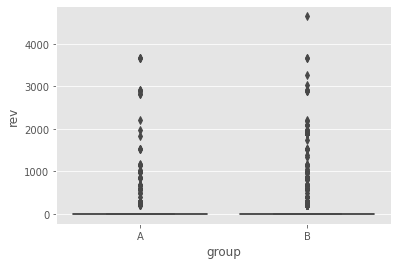

In [48]:
sns.boxplot(data=active_users_payments, x="group", y="rev") # из-за 0 медианы ничего непонятно

In [49]:
# проверка на гомогенность, первая - по медиане, вторая - для распределений с жирными хвостами
A_group = active_users_payments.query('group == "A"')['rev']
B_group = active_users_payments.query('group == "B"')['rev']

print(ss.levene(A_group, B_group))
print(ss.levene(A_group, B_group, center='trimmed'))

LeveneResult(statistic=1.5014608294336371, pvalue=0.22048133327049665)
LeveneResult(statistic=35.48612369205911, pvalue=2.6846518854431503e-09)


*Первый тест с p-value =  0.22, который используется при сравнении дисперсий выборок с ассиметричным распределением, не дает отклонить нулевую гипотезу о равности дисперсий, второй тест говорит об обратном. Даже с учетом того, что мы принимаем тот факт, что дисперсии равны, в выборках очень много выбросов, что негативно повлияет на сравнение средних и результаты t-теста. Поэтому в данном случае я бы использовал непараметричский тест Манна Уитни и бутстрап.*

In [50]:
A_group.quantile(q=0.99) # почти все пользователи, потратившие деньги, являются выбросами

1172.5999999999976

In [51]:
B_group.quantile(q=0.99)

1900.0

In [52]:
# сравним распределения тестом Манна-Уитни
ss.mannwhitneyu(A_group, B_group)

MannwhitneyuResult(statistic=5252113.0, pvalue=0.5099747992861601)

*Выборки имеют одинаковые распределения, мы не сможем отклонить нулевую гипотезу о их равенстве. Ради интереса проверим t-тестом:*

In [53]:
ss.ttest_ind(A_group, B_group, equal_var=False) # t-test Уэлча при различающихся дисперсиях - нет различий

Ttest_indResult(statistic=-1.2863738493797021, pvalue=0.1984358364145106)

In [54]:
ss.ttest_ind(A_group, B_group) # нет различий

Ttest_indResult(statistic=-1.225341107379344, pvalue=0.22048133326988403)

*Во всех случаях статистически значимых отличий обнаружить не удалось. Проверим мощность теста*

In [55]:
# сначала надо расчитать effect_size для неравных выборок
mean1 = np.mean(A_group)
mean2 = np.mean(B_group)
std1 = np.std(A_group)
std2 = np.std(B_group)
n1 = len(A_group)
n2 = len(B_group)
pooled_std = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1 + n2 - 2))
effect_size = (mean1 - mean2) / pooled_std

effect_size = effect_size
nobs = 1538
alpha = 0.05

TTestPower().solve_power(effect_size = effect_size,
                      nobs = nobs,
                      alpha = alpha,
                      power = None)

0.27342592864216636

*Мощность снова вышла недостаточной для того, чтобы обнаружить изменения, если они есть. Попробуем бутстрап, для которого каких-либо ограничений в плане распределений, дисперсий нет*

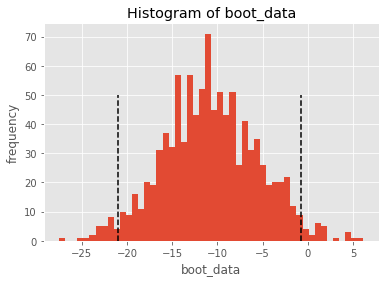

{'ci':                0
 0.025 -20.968852
 0.975  -0.712554,
 'p_value': 0.0387092736173035}

In [56]:
get_bootstrap(A_group, B_group)

*Бутстрап показал, что есть статистически значимое различие между средними двух выборок (0 не вошел в 95% доверительный интервал).*

### Выводы по ARPAU
Сплит система в норме, FPR не превышает заданный уровень ошибки первого рода. Проблема заключается в мощности тестов из-за сильного дисбаланса, чего стат критерии не любят. Маленькая мощность порождает получить с большей долей вероятности ошибку второго рода. В результате этого t-тест и U-тест не показали стат значимых различий, в отличие от бутстрапа. Я не совсем уверен в том, целесообразно ли применять в данном случае t-тест и целесообразно в принципе применение U-теста, поэтому в данном случае доверюсь результатам бутстрапа. Вывод - есть стат. значимое различие в двух выборках, ARPAU больше у пользователетй с новой механикой оплаты.

### Проверка ARPPU
В данном случае будем проверять средний чек на платящего пользователя, перекос размеров выборок здесь также будет существенный, выборки будут на порядок меньше. Все это также может повлиять на мощность тестов.

- H0: разницы между ARPPU двух групп нет
- Н1: есть статистически значимая разница между ARPPU контрольной и тестовой групп.

alpha=0.05

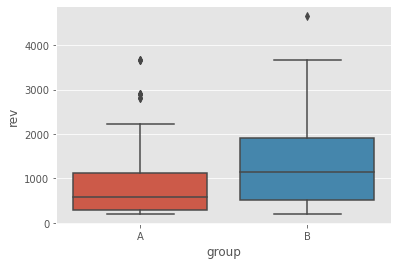

In [64]:
active_users_payments_not_0 = active_users_payments.query('rev > 0')
sns.boxplot(data=active_users_payments_not_0, x="group", y="rev") # выбросов стало меньше

In [65]:
A_not_0 = active_users_payments.query('rev > 0 and group == "A"')['rev']
B_not_0 = active_users_payments.query('rev > 0 and group == "B"')['rev']

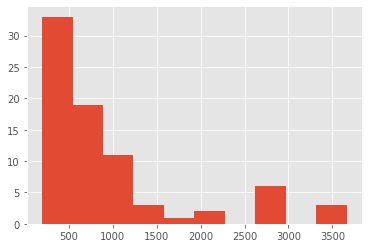

In [66]:
A_not_0.hist()

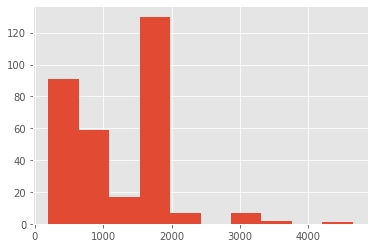

In [67]:
B_not_0.hist() # распределения немного отличаются по форме, во 2 группе большинство тех, кто заплатил от 1500 до 2000

*Логика сравнения выборок тут та же, что и с ARPAU, однако можно сравнить и медианы (правда это уже будет не ARPPU по определению). Исходя из боксплотов, по прежнему есть выбросы, исходя из чего среднее будет смещено вправо. В отличие от среднего, медиана робастна к выбросам*

*Я бы не стал использовать в данном случае t-тест из-за выбросов, а использовал бы U-тест ради интереса и бутстрап как основной критерий для принятия решения, при чем сравнил бы средние и медианы*

In [68]:
ss.mannwhitneyu(A_not_0, B_not_0) # как и предполагалось, распределения отличаются

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

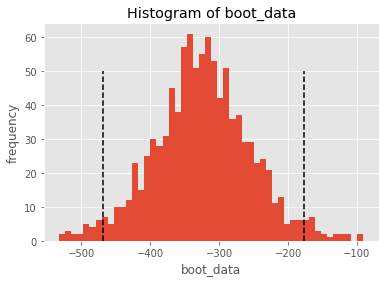

{'ci':                 0
 0.025 -469.076440
 0.975 -176.709245,
 'p_value': 3.706086726486042e-06}

In [69]:
# сравним средние
get_bootstrap(A_not_0, B_not_0)

In [70]:
# сравним медианы
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # берем медиану
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return { 
            "ci": ci, 
            "p_value": p_value}

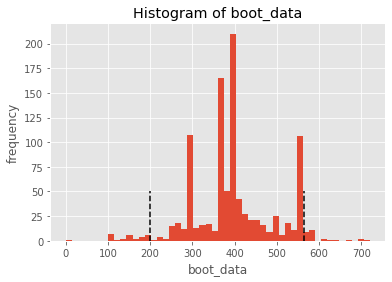

{'ci':               0
 0.025  198.7875
 0.975  565.1000,
 'p_value': 3.5005860667945524e-05}

In [71]:
get_bootstrap_median(B_not_0, A_not_0)

### Выводы по ARPPU
В данном случае все 3 теста показали стат значимые различия между выборками - разные распределения, разные средние и медианы. Это также было видно на боксплоте и распределениях

*Также из любопытства решил попробовать готовую библиотеку по бутстрапу, но не до конца понял по поводу суммы, которую рекомендуют использовать в качестве меры центральной тенденции, т.е. искомой статистики. Исходя из комментариев к коду, сумму рекомендуют использовать в тех случаях, когда хотим учесть размеры выборок, т.е. как я понял, при дисбалансе*

https://github.com/facebookarchive/bootstrapped/blob/master/examples/bootstrap_ab_testing.ipynb


In [72]:
# функции на вход просят нампаевский массив
A_not_0_ar = np.array(active_users_payments.query('rev > 0 and group == "A"')['rev'])
B_not_0_ar = np.array(active_users_payments.query('rev > 0 and group == "B"')['rev'])

In [73]:
print(bs.bootstrap_ab(
    A_not_0_ar, 
    B_not_0_ar, 
    stat_func=bs_stats.median,
    compare_func=bs_compare.percent_change
))

-48.68421052631579    (-67.06539074960128, -25.5)


In [74]:
print(bs.bootstrap_ab(
    A_not_0_ar, 
    B_not_0_ar, 
    stat_func=bs_stats.mean,
    compare_func=bs_compare.percent_change
))

-25.780639513106717    (-44.127962823490286, -9.8980779272027)


In [75]:
print(bs.bootstrap_ab(
    A_not_0_ar, 
    B_not_0_ar, 
    stat_func=bs_stats.sum,
    compare_func=bs_compare.percent_change
))

-81.5633435733195    (-86.04849804768851, -77.77833979199737)


*Главное, что и в этих тестах доверительный интервал не включает 0*

*Также проверим и ARPAU, в качестве меры центральной тенденции воспользуемся суммой и средним*

In [76]:
A_group_active = np.array(active_users_payments.query('group == "A"')['rev'])
B_group_active = np.array(active_users_payments.query('group == "B"')['rev'])

In [77]:
# есть стат. значимые различия, используя сумму в качестве статистики
print(bs.bootstrap_ab(
    A_group_active, 
    B_group_active, 
    stat_func=bs_stats.sum,
    compare_func=bs_compare.percent_change
))

-81.5633435733195    (-88.33061795321053, -75.96259323856147)


In [78]:
# нет стат. значимых различий, используя среднее в качестве статистики
print(bs.bootstrap_ab(
    A_group_active, 
    B_group_active, 
    stat_func=bs_stats.mean,
    compare_func=bs_compare.percent_change
))

-18.449561982634965    (-48.19491300667572, 6.7764076900157235)


*По идее, среднее и сумма это одно и то же, только среднее как раз должно учитывать размеры групп. В общем буду искать информацию по этому поводу, а пока больше доверюсь лекционной функции, принцип работы которой я понимаю*

# Выводы по заданию 1
Выводы будут зависеть от того, какие метрики мы определили целевыми перед началом A/B теста. Если мы хотели увеличить CR в покупку у активных пользователей, то сделать нам это не удалось. Хотя по идее, при тестировании новой мехиники оплаты именно конверсия, на мой взгляд, должна быть целевой метрикой. Это объясняется тем, что механика оплаты имеет большее значение при самом факте оплаты (предположу, что в новую механику добавили новый способ оплаты, который на наш взгляд должен был увеличить число платящих пользователей). Я бы не стал вводить новую механику оплаты, а продлил тест или разбил бы тестувую и контрольную группы на равное число пользователей для увеличения мощности теста.

Если наша целевая метрика ARPAU, то я бы скорее запустил новую механику на всех пользователей, так как различия между средними статистически значимы. Меня смущает тот факт, что в тесте мы сравниваем среднее, которое сильно искажается выбросами, которыми можно считать в выборках как 0, так и все значения, которые больше 0.

Если наша целевая метрика ARPPU, то я бы точно запустил новую механику на всю аудиторию, так как средние и медианы статистически значимо отличаются.

# Задание 2. SQL
**2.1 Очень усердные ученики.**

**2.1.1 Условие**

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

**2.1.2 Задача**

Дана таблица default.peas:

```
| Название атрибута |Тип атрибута | Смысловое значение                       |
|-------------------+-------------+------------------------------------------|
| st_id             | int         | ID ученика                               |
|-------------------+-------------+------------------------------------------|
| timest            | timestamp   | Время решения карточки                   |
|-------------------+-------------+------------------------------------------|
| correct           | bool        | Правильно ли решена горошина?            |
|-------------------+-------------+------------------------------------------|
| subject           | text        | Дисциплина, в которой находится горошина |
```

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

In [79]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [80]:
# посмотрим, на месяцы и число учеников
query_month = """
SELECT 
    CAST(min(timest) AS Date) AS min_month,
    CAST(max(timest) AS Date) AS max_month,
    countdistinct(st_id) AS all_students
FROM
    default.peas;
"""

In [81]:
info_1 = ph.read_clickhouse(query_month, connection=connection_default)
info_1

,min_month,max_month,all_students
0,2021-10-30,2021-10-31,308


In [82]:
# посмотрим на всякий случай на тип данных
types_of_data = '''
DESCRIBE TABLE default.peas
'''

In [83]:
info_1_2 = ph.read_clickhouse(types_of_data, connection=connection_default)
info_1_2

,name,type,default_type,default_expression,comment,codec_expression,ttl_expression
0,st_id,String,,,,,
1,timest,DateTime64(3),,,,,
2,correct,Int8,,,,,
3,subject,String,,,,,


*С учетом того, что в таблице лежат данные только за два дня, то запрос можно существенно сократить*

In [84]:
query_1 = """
SELECT
    COUNT(*) AS number_of_students
FROM (
    SELECT
        SUM(correct) AS sum_of_students
    FROM
        default.peas
    GROUP BY
        CAST(st_id AS UInt32) -- изначально у id строковый тип
    HAVING
        sum_of_students >= 20
    )
"""

In [85]:
df1 = ph.read_clickhouse(query_1, connection=connection_default)
df1

,number_of_students
0,136


*Если месяцев было бы несколько, то я бы привел месяцы к 1 числу каждого месяца и считал бы месяц, который надо взять по условию*

In [86]:
# на самом деле и без приведения типов считалось корректно
query_1_2 = """
SELECT
    COUNT(*) AS number_of_students
FROM (
    SELECT
        SUM(correct) AS SUM,
        toStartOfMonth(timest) AS month
    FROM
        default.peas
    GROUP BY
        CAST(st_id AS UInt32),
        toStartOfMonth(timest)
    HAVING
        SUM >= 20)
WHERE
    month = '2021-10-01'
"""

In [87]:
df1_2 = ph.read_clickhouse(query_1, connection=connection_default)
df1_2

,number_of_students
0,136


### 2.2 Оптимизация воронки

**2.2.1 Условие**

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Даны 3 таблицы:

таблица **default.peas:**

```
| Название атрибута |Тип атрибута | Смысловое значение                       |
|-------------------+-------------+------------------------------------------|
| st_id             | int         | ID ученика                               |
|-------------------+-------------+------------------------------------------|
| timest            | timestamp   | Время решения карточки                   |
|-------------------+-------------+------------------------------------------|
| correct           | bool        | Правильно ли решена горошина?            |
|-------------------+-------------+------------------------------------------|
| subject           | text        | Дисциплина, в которой находится горошина |
```
таблица **default.studs:**

```
| Название атрибута |Тип атрибута | Смысловое значение                       |
|-------------------+-------------+------------------------------------------|
| st_id             | int         | ID ученика                               |
|-------------------+-------------+------------------------------------------|
| test_grp          | text        | Метка ученика в данном эксперименте      |
|-------------------+-------------+------------------------------------------|

```
таблица **default.final_project_check:**
```
| Название атрибута |Тип атрибута | Смысловое значение                       |
|-------------------+-------------+------------------------------------------|
| st_id             | int         | ID ученика                               |
|-------------------+-------------+------------------------------------------|
| sale_time         | timestamp   | Время покупки                            |
|-------------------+-------------+------------------------------------------|
| money             | int         | Цена, по которой приобрели данный курс   |
|-------------------+-------------+------------------------------------------|
| subject           | text        | Дисциплина, в которой находится горошина |
```

**Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:**
- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [88]:
# смотрим на тип данных
types_of_data = '''
DESCRIBE TABLE default.studs
'''

In [89]:
info_2_1 = ph.read_clickhouse(types_of_data, connection=connection_default)
info_2_1

,name,type,default_type,default_expression,comment,codec_expression,ttl_expression
0,st_id,String,,,,,
1,test_grp,String,,,,,


In [90]:
# смотрим на тип данных
types_of_data = '''
DESCRIBE TABLE default.final_project_check
'''

In [91]:
info_2_2 = ph.read_clickhouse(types_of_data, connection=connection_default)
info_2_2

,name,type,default_type,default_expression,comment,codec_expression,ttl_expression
0,st_id,String,,,,,
1,sale_time,DateTime64(3),,,,,
2,money,UInt32,,,,,
3,subject,String,,,,,


In [92]:
# посмотрим на число уникальных юзеров в каждой колонке
users_1 = '''
SELECT
    uniqExact(st_id)
FROM
    default.peas 
'''

users_2 = '''
SELECT
    uniqExact(st_id)
FROM
    default.studs 
'''

users_3 = '''
SELECT
    uniqExact(st_id)
FROM
    default.final_project_check 
'''

In [93]:
print(ph.read_clickhouse(users_1, connection=connection_default))
print(ph.read_clickhouse(users_2, connection=connection_default))
print(ph.read_clickhouse(users_3, connection=connection_default))

   uniqExact(st_id)
0               308
   uniqExact(st_id)
0               600
   uniqExact(st_id)
0                47


*308 человек, которые что-то решали, 600 человек всего, 47 из которых купили хотя бы 1 дисциплину.*

In [94]:
# посмотрим на разбивку
studs = '''
SELECT
    COUNT(*), 
    test_grp
FROM
    default.studs
GROUP BY
    test_grp
'''

In [95]:
ph.read_clickhouse(studs, connection=connection_default)

,count(),test_grp
0,305,control
1,295,pilot


In [96]:
# посмотрим на число строк в каждой таблице, пригодится при джойнах
size_1 = '''SELECT COUNT(*) FROM default.peas'''
size_2 = '''SELECT COUNT(*) FROM default.studs'''
size_3 = '''SELECT COUNT(*) FROM default.final_project_check'''

In [97]:
print(ph.read_clickhouse(size_1, connection=connection_default))
print(ph.read_clickhouse(size_2, connection=connection_default))
print(ph.read_clickhouse(size_3, connection=connection_default))

   count()
0    13245
   count()
0      600
   count()
0       61


Исходя из задания, финальная таблица может выглядеть следующим образом:
````
| Группы    |ARPU         | ARPAU     |CR в покупку|СR активного пользователя в покупку| CR активных по математике
|-----------+-------------+-----------+------------+-----------------------------------+---------------------------
| control   | значение    | значение  |значение    | значение                          |значение
|-----------+-------------+-----------+------------+-----------------------------------+---------------------------
| pilot     | значение    | значение  |значение    | значение                          |значение                      
|-----------+-------------+-----------+------------+-----------------------------------+---------------------------
````
Подобную таблицу можно построить при помощи подзапросов и джойнов, т.е. подзапрос должен будет выводить группу и 1 метрику, а потом джойн, где ключом будет группа.

Делать я буду итерациями, по отдельности выводить каждую метрику. В конце будет запрос целиком, как требуется в задании.

## ARPU

In [98]:
# посмотрим, сколько потратила каждая группа
money_all = '''
SELECT
    group,
    SUM(money) AS sum_of_money
FROM
    (SELECT
        l.st_id AS st_id,
        l.money AS money,
        r.test_grp AS group
    FROM
         default.final_project_check AS l -- клеим группы с деньгами
    LEFT JOIN
        default.studs AS r
        USING (st_id)
    )
GROUP BY
    group
'''

In [99]:
money_table = ph.read_clickhouse(money_all, connection=connection_default)
money_table

,group,sum_of_money
0,control,1385000
1,pilot,3395000


In [100]:
query_money='''
SELECT
    st_id,
    money
FROM
    default.final_project_check 
'''

In [101]:
t = ph.read_clickhouse(query_money, connection=connection_default)
t

,st_id,money
0,101432,85000
1,101432,65000
2,104885,65000
3,104885,75000
4,106464,85000
...,...,...
56,969595,65000
57,969595,75000
58,969595,100000
59,976866,85000


In [102]:
print(sum(t['money']))
sum(t['money']) == sum(money_table['sum_of_money'])

4780000


True

In [103]:
# ARPU рассчитывается как все деньги / все пользователи
query_arpu = '''
SELECT
    group,
    sum_of_money / number_of_students AS ARPU
FROM
    (SELECT
        group,
        SUM(money) AS sum_of_money
    FROM
        (SELECT
            l.st_id AS st_id,
            l.money AS money,
            r.test_grp AS group
        FROM
             default.final_project_check AS l -- клеим группы с деньгами
        LEFT JOIN
            default.studs AS r
            USING (st_id)
        )
    GROUP BY
        group) AS l2
LEFT JOIN               -- клеим число людей в каждой группе с деньгами
    (SELECT
        COUNT(*) AS number_of_students, 
        test_grp AS group
    FROM
        default.studs
    GROUP BY
        test_grp) AS r2
    USING (group)
'''

In [104]:
arpu_table = ph.read_clickhouse(query_arpu, connection=connection_default)
arpu_table

,group,ARPU
0,control,4540.983607
1,pilot,11508.474576


In [105]:
# обернем ph.read_clickhouse в функцию для удобства
def read(query):
    return ph.read_clickhouse(query, connection=connection_default)

In [106]:
arpu_table = read(query_arpu)
arpu_table

,group,ARPU
0,control,4540.983607
1,pilot,11508.474576


## ARPAU
Average Revenue Per Active User - средняя выручка на активного пользователя, т.е. все деньги (по аналогии с arpu и arppu)/ число активных пользователей. Активные пользователи те, которые решили больше 10 заданий за все время.

Запрос будет похож на предыдущий, только предварительно надо будет отфильтровать пользоваталей с 11 и более задачами, приклеить к ним группу, сгруппировать по группе, и посчитать пользоваталей в каждой. С деньгами запрос будет аналогичен предыдущему.

In [107]:
# таблица с юзерами, у которых больше 10 правильных решений, всего 223 юзера
active_uesrs = '''
SELECT
    *
FROM
    (SELECT
        st_id,
        SUM(correct) AS sum_of_points
    FROM
        default.peas
    GROUP BY
        st_id
    HAVING
        SUM(correct) > 10) AS l_arpau
LEFT JOIN
    default.studs AS r_arpau
    USING(st_id)
'''

In [108]:
read(active_uesrs).sort_values('sum_of_points')

,st_id,sum_of_points,test_grp
222,70509,11,control
178,591725,11,control
166,277530,11,pilot
4,373937,11,control
124,349833,11,pilot
...,...,...,...
107,434775,79,pilot
67,234705,81,pilot
11,577659,111,pilot
100,976310,121,control


In [109]:
number_of_active='''
SELECT
    test_grp AS group,
    COUNT(*)
FROM
    (SELECT
        *
    FROM
        (SELECT
            st_id,
            SUM(correct) AS sum_of_points
        FROM
            default.peas
        GROUP BY
            st_id
        HAVING
            SUM(correct) > 10) AS l_ponts
    LEFT JOIN
        default.studs AS r_number_of_active
        USING(st_id)
        )
GROUP BY
    test_grp
'''

In [110]:
read(number_of_active)

,group,count()
0,control,127
1,pilot,96


In [111]:
# объединив, получаем
ARPAU = '''
SELECT
    group,
    sum_of_money / number_of_active_users AS ARPAU
FROM
    (SELECT
        test_grp AS group,
        COUNT(*) AS number_of_active_users
    FROM
        (SELECT
            *
        FROM
            (SELECT
                st_id,
                SUM(correct) AS sum_of_points
            FROM
                default.peas
            GROUP BY
                st_id
            HAVING
                SUM(correct) > 10) AS l_ponts
        LEFT JOIN
            default.studs AS r_number_of_active
            USING(st_id)
            )
    GROUP BY
        test_grp) AS number_of_active_by_groups
JOIN
    (SELECT
        group,
        SUM(money) AS sum_of_money
    FROM
        (SELECT
            l.st_id AS st_id,
            l.money AS money,
            r.test_grp AS group
        FROM
             default.final_project_check AS l -- клеим группы с деньгами
        LEFT JOIN
            default.studs AS r
            USING (st_id)
        )
    GROUP BY
        group) AS money_by_groups
    USING(group)
'''

In [112]:
read(ARPAU)

,group,ARPAU
0,control,10905.511811
1,pilot,35364.583333


## CR в покупку
число уникальных купивших юзеров / общее число юзеров

В чеках надо оставить только уникальных пользователей, приклеить к ним группы, а потом поделить их число на всех пользоваталей (надо приклеить к ним запрос `studs`, который считает число студентов в группах.

In [113]:
# Сделаем запрос о числе купивших курс в каждой группе
nuniq_payments = '''
SELECT
    group,
    uniqExact( un_id) AS number_of_paments
FROM
    (
    SELECT
        DISTINCT(unique_pay_users.st_id) AS un_id,
        groups.test_grp AS group
    FROM
        default.final_project_check AS unique_pay_users
    JOIN
        default.studs AS groups
        USING(st_id)
    )
GROUP BY
    group
'''

In [114]:
read(nuniq_payments) # по сумме купивших все совпадает

,group,number_of_paments
0,control,15
1,pilot,32


In [115]:
# соединив nuniq_payments и запрос studs, получаем CR по группам
CR = '''
SELECT
    nuniq_payments.group AS group,
    number_of_paments / num_users AS CR
FROM
    (SELECT
        group,
        uniqExact( un_id) AS number_of_paments
    FROM
        (
        SELECT
            DISTINCT(unique_pay_users.st_id) AS un_id,
            groups.test_grp AS group
        FROM
            default.final_project_check AS unique_pay_users
        JOIN
            default.studs AS groups
            USING(st_id)
        )
    GROUP BY
        group) AS nuniq_payments
    JOIN
        (SELECT
            COUNT(*) AS num_users,
            test_grp
        FROM
            default.studs
        GROUP BY
            test_grp) AS users_by_group
    ON
        users_by_group.test_grp = nuniq_payments.group
'''

In [116]:
read(CR)

,group,CR
0,control,0.049180
1,pilot,0.108475


## СR активного пользователя в покупку
CR активного пользователя это число активных купивших / число активных пользователей. Число активных пользоваталей мы уже находили, надо найти тех, кто из активных что то купил

In [117]:
# выведем список всех активных пользователей. Далее их их нужно соединить с покупателями внутренним джойном
active_uesers_all = '''
SELECT
    st_id AS active_user,
    r_number_of_active.test_grp AS group
FROM
    (SELECT
        st_id,
        SUM(correct) AS sum_of_points
    FROM
        default.peas
    GROUP BY
        st_id
    HAVING
        SUM(correct) > 10) AS l_ponts
LEFT JOIN
    default.studs AS r_number_of_active
    USING(st_id)
'''

In [118]:
read(active_uesers_all)

,active_user,group
0,414769,control
1,700123,control
2,171209,control
3,289442,control
4,373937,control
...,...,...
218,370427,control
219,421765,pilot
220,790532,pilot
221,594177,control


In [119]:
# активные пользователи, которые делали покупки, по группам
active_buyers = '''
SELECT
    COUNT(active_uesers_all.active_user) AS number_of_pay_act_user,
    group
FROM
    (
    SELECT
        st_id AS active_user,
        r_number_of_active.test_grp AS group
    FROM
        (SELECT
            st_id,
            SUM(correct) AS sum_of_points
        FROM
            default.peas
        GROUP BY
            st_id
        HAVING
            SUM(correct) > 10) AS l_ponts
    LEFT JOIN
        default.studs AS r_number_of_active
        USING(st_id)
    ) AS active_uesers_all
    JOIN
    (SELECT
        DISTINCT(st_id) AS st_id
    FROM
        default.final_project_check
    ) AS payments
    ON
    payments.st_id = active_uesers_all.active_user
GROUP BY
    group
'''

In [120]:
read(active_buyers)

,number_of_pay_act_user,group
0,14,control
1,25,pilot


In [121]:
# далее цепляем две таблицы, предварительно сделав группировку в активных
active_CR = '''
SELECT
    active_buyers.group AS group,
    number_of_pay_act_user / active_all AS active_CR
FROM
    (SELECT
        test_grp AS group,
        COUNT(*) AS active_all
    FROM
        (SELECT
            *
        FROM
            (SELECT
                st_id,
                SUM(correct) AS sum_of_points
            FROM
                default.peas
            GROUP BY
                st_id
            HAVING
                SUM(correct) > 10) AS l_ponts
        LEFT JOIN
            default.studs AS r_number_of_active
            USING(st_id)
            )
    GROUP BY
        test_grp) AS active_by_groups
    JOIN
        (SELECT
            COUNT(active_uesers_all.active_user) AS number_of_pay_act_user,
            group
        FROM
            (
            SELECT
                st_id AS active_user,
                r_number_of_active.test_grp AS group
            FROM
                (SELECT
                    st_id,
                    SUM(correct) AS sum_of_points
                FROM
                    default.peas
                GROUP BY
                    st_id
                HAVING
                    SUM(correct) > 10) AS l_ponts
            LEFT JOIN
                default.studs AS r_number_of_active
                USING(st_id)
            ) AS active_uesers_all
            JOIN
            (SELECT
                DISTINCT(st_id) AS st_id
            FROM
                default.final_project_check
            ) AS payments
            ON
            payments.st_id = active_uesers_all.active_user
        GROUP BY
            group) AS active_buyers
    ON
       active_buyers.group = active_by_groups.group
'''

In [122]:
read(active_CR)

,group,active_CR
0,control,0.110236
1,pilot,0.260417


## CR пользователя из активности по математике в покупку курса по математике
Нужно найти всех активных студентов по математике - те, у кого не меньше 2 правильно выполненных задач по математике. Также нужно найти тех, кто купил курс по математике и был активным в ней. Далее надо поделить вторых на первых.

In [123]:
# посмотрим, какие вообще есть дисциплины
subjects = '''
SELECT
    DISTINCT(subject)
FROM
    default.peas
'''

In [124]:
read(subjects)

,subject
0,Theory of probability
1,Vizualization
2,Python
3,Statistics
4,Math


In [125]:
# отберем активных математиков
math_active_st = '''
SELECT
    st_id,
    SUM(correct) AS points_of_math
FROM
    default.peas
WHERE
    subject = 'Math'
GROUP BY
    st_id
HAVING
    points_of_math >= 2
ORDER BY
    points_of_math
'''

In [126]:
read(math_active_st) # всего 91 студент (также проверил, что не было студентов с 2 баллами)

,st_id,points_of_math
0,921919,3
1,973519,3
2,969749,3
3,332988,3
4,726051,3
...,...,...
86,750680,31
87,760034,32
88,706735,38
89,489093,43


In [127]:
# найдем число активных математиков в каждой группе
math_by_groups = '''
SELECT
    groups.test_grp AS group,
    COUNT(*) AS number_of_math
FROM
    (SELECT
        st_id,
        SUM(correct) AS points_of_math
    FROM
        default.peas
    WHERE
        subject = 'Math'
    GROUP BY
        st_id
    HAVING
        points_of_math >= 2) AS math_students
    LEFT JOIN
        default.studs AS groups
        USING(st_id)
GROUP BY
    groups.test_grp 
'''

In [128]:
read(math_by_groups)

,group,number_of_math
0,control,49
1,pilot,42


In [129]:
# теперь найдем среди активных математиков тех, кто купил курс по математике
active_buyers_math = '''
SELECT
    COUNT(st_id),
    test_grp AS group
FROM
    (SELECT
        st_id
    FROM
        (SELECT
            st_id,
            SUM(correct) AS points_of_math
        FROM
            default.peas
        WHERE
            subject = 'Math'
        GROUP BY
            st_id
        HAVING
            points_of_math >= 2) AS math_active_st
        JOIN
        (SELECT
            DISTINCT(st_id) AS st_id
        FROM
            default.final_project_check
        WHERE
            subject = 'Math'
        ) AS buyers_math
        USING(st_id)) AS math_active_buyets
    LEFT JOIN
        default.studs AS groups
    USING(st_id)
GROUP BY
    test_grp
 '''

In [130]:
read(active_buyers_math)

,count(st_id),group
0,3,control
1,4,pilot


In [131]:
# соединим и получим нужную метрику
active_cr_math = '''
SELECT
    group,
    num_buyers / number_of_math AS active_cr_math
FROM
    (SELECT
        groups.test_grp AS group,
        COUNT(*) AS number_of_math
    FROM
        (SELECT
            st_id,
            SUM(correct) AS points_of_math
        FROM
            default.peas
        WHERE
            subject = 'Math'
        GROUP BY
            st_id
        HAVING
            points_of_math >= 2) AS math_students
        LEFT JOIN
            default.studs AS groups
            USING(st_id)
    GROUP BY
        groups.test_grp) AS math_by_groups
    JOIN
    (SELECT
        COUNT(st_id) AS num_buyers,
        test_grp AS group
    FROM
        (SELECT
            st_id
        FROM
            (SELECT
                st_id,
                SUM(correct) AS points_of_math
            FROM
                default.peas
            WHERE
                subject = 'Math'
            GROUP BY
                st_id
            HAVING
                points_of_math >= 2) AS math_active_st
            JOIN
            (SELECT
                DISTINCT(st_id) AS st_id
            FROM
                default.final_project_check
            WHERE
                subject = 'Math'
            ) AS buyers_math
            USING(st_id)) AS math_active_buyets
        LEFT JOIN
            default.studs AS groups
        USING(st_id)
    GROUP BY
        test_grp) AS active_buyers_math
        ON
        active_buyers_math.group = math_by_groups.group'''

In [132]:
read(active_cr_math)

,group,active_cr_math
0,control,0.061224
1,pilot,0.095238


In [133]:
# теперь можно объединить все запросы в один
final_query = '''
SELECT
    ARPU_table.group AS group,
    ARPU_table.ARPU AS ARPU,
    ARPAU_table.ARPAU AS ARPAU,
    CR_table.CR AS CR,
    CR_active_table.active_CR AS active_CR,
    math_CR.active_cr_math
FROM
    (SELECT
        group,
        sum_of_money / number_of_students AS ARPU
    FROM
        (SELECT
            group,
            SUM(money) AS sum_of_money
        FROM
            (SELECT
                l.st_id AS st_id,
                l.money AS money,
                r.test_grp AS group
            FROM
                 default.final_project_check AS l -- клеим группы с деньгами
            LEFT JOIN
                default.studs AS r
                USING (st_id)
            )
        GROUP BY
            group) AS l2
    LEFT JOIN               -- клеим число людей в каждой группе с деньгами
        (SELECT
            COUNT(*) AS number_of_students, 
            test_grp AS group
        FROM
            default.studs
        GROUP BY
            test_grp) AS r2
        USING (group)) AS ARPU_table ---------------------------
        JOIN
        (SELECT
            group,
            sum_of_money / number_of_active_users AS ARPAU
        FROM
            (SELECT
                test_grp AS group,
                COUNT(*) AS number_of_active_users
            FROM
                (SELECT
                    *
                FROM
                    (SELECT
                        st_id,
                        SUM(correct) AS sum_of_points
                    FROM
                        default.peas
                    GROUP BY
                        st_id
                    HAVING
                        SUM(correct) > 10) AS l_ponts
                LEFT JOIN
                    default.studs AS r_number_of_active
                    USING(st_id)
                    )
            GROUP BY
                test_grp) AS number_of_active_by_groups
        JOIN
            (SELECT
                group,
                SUM(money) AS sum_of_money
            FROM
                (SELECT
                    l.st_id AS st_id,
                    l.money AS money,
                    r.test_grp AS group
                FROM
                     default.final_project_check AS l -- клеим группы с деньгами
                LEFT JOIN
                    default.studs AS r
                    USING (st_id)
                )
            GROUP BY
                group) AS money_by_groups
            USING(group)) AS ARPAU_table ----------------
        USING(group)
        JOIN
            (SELECT
                nuniq_payments.group AS group,
                number_of_paments / num_users AS CR
            FROM
                (SELECT
                    group,
                    uniqExact( un_id) AS number_of_paments
                FROM
                    (
                    SELECT
                        DISTINCT(unique_pay_users.st_id) AS un_id,
                        groups.test_grp AS group
                    FROM
                        default.final_project_check AS unique_pay_users
                    JOIN
                        default.studs AS groups
                        USING(st_id)
                    )
                GROUP BY
                    group) AS nuniq_payments
                JOIN
                    (SELECT
                        COUNT(*) AS num_users,
                        test_grp
                    FROM
                        default.studs
                    GROUP BY
                        test_grp) AS users_by_group
                ON
                    users_by_group.test_grp = nuniq_payments.group) AS CR_table
        ON
        CR_table.group = ARPAU_table.group
        JOIN
            (SELECT
                active_buyers.group AS group,
                number_of_pay_act_user / active_all AS active_CR
            FROM
                (SELECT
                    test_grp AS group,
                    COUNT(*) AS active_all
                FROM
                    (SELECT
                        *
                    FROM
                        (SELECT
                            st_id,
                            SUM(correct) AS sum_of_points
                        FROM
                            default.peas
                        GROUP BY
                            st_id
                        HAVING
                            SUM(correct) > 10) AS l_ponts
                    LEFT JOIN
                        default.studs AS r_number_of_active
                        USING(st_id)
                        )
                GROUP BY
                    test_grp) AS active_by_groups
                JOIN
                    (SELECT
                        COUNT(active_uesers_all.active_user) AS number_of_pay_act_user,
                        group
                    FROM
                        (
                        SELECT
                            st_id AS active_user,
                            r_number_of_active.test_grp AS group
                        FROM
                            (SELECT
                                st_id,
                                SUM(correct) AS sum_of_points
                            FROM
                                default.peas
                            GROUP BY
                                st_id
                            HAVING
                                SUM(correct) > 10) AS l_ponts
                        LEFT JOIN
                            default.studs AS r_number_of_active
                            USING(st_id)
                        ) AS active_uesers_all
                        JOIN
                        (SELECT
                            DISTINCT(st_id) AS st_id
                        FROM
                            default.final_project_check
                        ) AS payments
                        ON
                        payments.st_id = active_uesers_all.active_user
                    GROUP BY
                        group) AS active_buyers
                    ON
                       active_buyers.group = active_by_groups.group) AS CR_active_table ----------------
       ON
       CR_active_table.group = ARPAU_table.group
       JOIN
       (SELECT
            group,
            num_buyers / number_of_math AS active_cr_math
        FROM
            (SELECT
                groups.test_grp AS group,
                COUNT(*) AS number_of_math
            FROM
                (SELECT
                    st_id,
                    SUM(correct) AS points_of_math
                FROM
                    default.peas
                WHERE
                    subject = 'Math'
                GROUP BY
                    st_id
                HAVING
                    points_of_math >= 2) AS math_students
                LEFT JOIN
                    default.studs AS groups
                    USING(st_id)
            GROUP BY
                groups.test_grp) AS math_by_groups
            JOIN
            (SELECT
                COUNT(st_id) AS num_buyers,
                test_grp AS group
            FROM
                (SELECT
                    st_id
                FROM
                    (SELECT
                        st_id,
                        SUM(correct) AS points_of_math
                    FROM
                        default.peas
                    WHERE
                        subject = 'Math'
                    GROUP BY
                        st_id
                    HAVING
                        points_of_math >= 2) AS math_active_st
                    JOIN
                    (SELECT
                        DISTINCT(st_id) AS st_id
                    FROM
                        default.final_project_check
                    WHERE
                        subject = 'Math'
                    ) AS buyers_math
                    USING(st_id)) AS math_active_buyets
                LEFT JOIN
                    default.studs AS groups
                USING(st_id)
            GROUP BY
                test_grp) AS active_buyers_math
                ON
                active_buyers_math.group = math_by_groups.group) AS math_CR
            ON
            math_CR.group = CR_active_table.group
'''

*Код получился слишком громоздким, но рабочим (в кликхаусе, пандахаус его не прожевал). Однако, подозреваю, для больших данных это ужасный код, который я пока думаю как исправить*

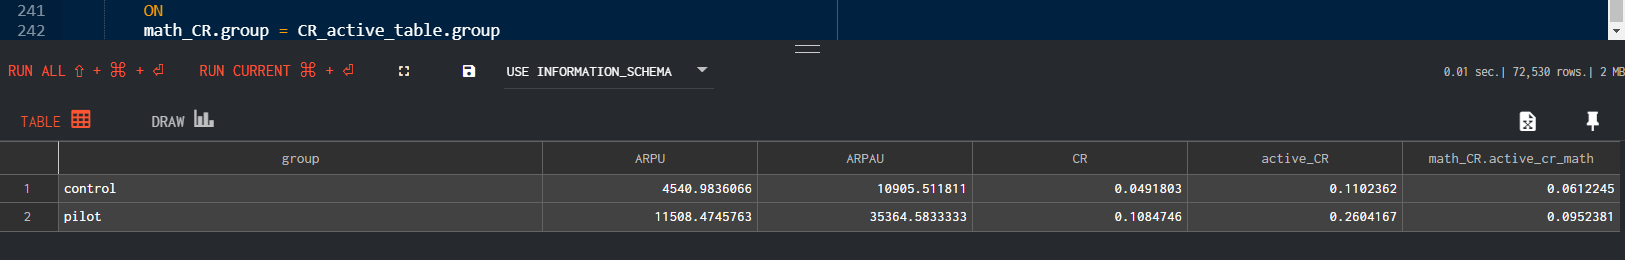

# Задание 3. Python
## 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

*Допустим, у нас есть уже 3 прочитанных файла, а именно **groups, active_users и checks**. Тогда функция на вход будет брать ссылку на файл (или путь) с добавочными пользователями*

In [134]:
def ab_with_add(x):
    
    '''
    Функция учитывает добавочный файл и возвращает пересчитанные значения метрик 
    после проведения А/Б-теста при внедрении новой механики оплаты. Пересчитанные 
    метрики:конверсии в покупку, ARPAU и ARPPU активных пользователей. 
    Проверяются различия в двух группах на стат. значимость. 
    На вход подается путь или ссылка файла с доп. пользователями. 
    Затем происходит объединение таблиц и вычисление необходимых показателей.
    Также функция рисует графики полученных результатов и некоторые полезные 
    графики, например, распределения выручки по группам.
    '''
        
    # считывание данных, на вход путь к файлу или ссылка
    
    add_group = pd.read_csv(x)
    if len(add_group.columns) == 1:
        add_group = pd.read_csv(x, sep=';')
    add_group.columns = groups.columns
    
    all_group = pd.concat([groups, add_group])
    
    if all_group['id'].nunique() != len(groups_all):
        check_len =  "Ошибка данных из-за неправильной разбивки пользоваталей!!!"
    else:
        check_len = ''
    groups_all.columns = ['student_id', 'group']
    
    
    # Объединим файлы, чтобы получить таблицу активных пользователей с чеками
  
    active_users = active.merge(groups_all, how='left', on='student_id')
    active_users_payments = active_users.merge(checks, how='left', on='student_id')
    active_users_payments = active_users_payments.fillna(0)
    
    # Смотрим CR, проверяем на стат. значимость
    
    active_users_payments['status'] = active_users_payments['rev'] > 0
    chi_sq = active_users_payments.groupby('group', as_index=False) \
                            .agg({'rev': 'count', 'status': 'sum'}) \
                            .rename(columns={'rev':'all', 'status': 'payments'})
    
    cr_active_A = round(chi_sq['payments'][0] / chi_sq['all'][0], 4)
    cr_active_B = round(chi_sq['payments'][1] / chi_sq['all'][1], 4)
    
    arr = np.array([[chi_sq['payments'][0], chi_sq['all'][0]],
                   [chi_sq['payments'][1], chi_sq['all'][1]]])
    result_chi2 = ss.chi2_contingency(arr)
    
    result_1 = f'Конврсия в покупку активных пользователей в группе А: {cr_active_A*100}%, \
в группе B: {cr_active_B*100}%.\n'
    
    if cr_active_A > cr_active_B:
        result_1 += f'''- Конверсия в группе А выше, чем в B на {round((cr_active_A / cr_active_B - 1)*100, 2)}% \
или на {round((cr_active_A - cr_active_B), 3)} п.п.'''
    elif cr_active_A < cr_active_B:
        result_1 += f'''- Конверсия в группе B выше, чем в A на {round((cr_active_B / cr_active_A - 1)*100, 2)}% \
или на {round((cr_active_B - cr_active_A), 3)} п.п.'''
    else:
        result_1 += f'- Конверсии равны и составляют {cr_active_A}'
        
    if result_chi2[1] >= 0.05:
        result_chi2_p = f'Между выборками нет стат. значимых различий, p-value = {round(result_chi2[1], 3)}, \
в силе остается нулевая гипотеза о том, что CR в покупку не зависит от группы'
    elif result_chi2[1] < 0.05:
        result_chi2_p = f'Между выборками есть стат. значимые различия, p-value = {round(result_chi2[1], 3)}, \
принимается альтернативная гипотеза о том, что CR в покупку зависит от группы'
    

    # Сравниваем ARPAU при помощи бутстрапа, будем сравнивать средние

    mean_arpau = active_users_payments.groupby('group') \
                                    .agg({'rev': 'mean'}) \
                                    .reset_index()
    mean_arpau_A = round(mean_arpau['rev'][0], 2)
    mean_arpau_B = round(mean_arpau['rev'][1], 2)
    
    A_group = active_users_payments.query('group == "A"')['rev']
    B_group = active_users_payments.query('group == "B"')['rev']
    
    def get_bootstrap(
        data_column_1, # числовые значения первой выборки
        data_column_2, # числовые значения второй выборки
        boot_it = 1000, # количество бутстрап-подвыборок
        statistic = np.mean, # интересующая нас статистика
        bootstrap_conf_level = 0.95 # уровень значимости
    ):
        boot_len = max([len(data_column_1), len(data_column_2)])
        boot_data = []
        for i in range(boot_it): # извлекаем подвыборки
            samples_1 = data_column_1.sample(
                boot_len, 
                replace = True # параметр возвращения
            ).values

            samples_2 = data_column_2.sample(
                boot_len, 
                replace = True
            ).values

            boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику

        pd_boot_data = pd.DataFrame(boot_data)

        left_quant = (1 - bootstrap_conf_level)/2
        right_quant = 1 - (1 - bootstrap_conf_level) / 2
        ci = pd_boot_data.quantile([left_quant, right_quant])

        p_1 = ss.norm.cdf(
            x = 0, 
            loc = np.mean(boot_data), 
            scale = np.std(boot_data)
        )
        p_2 = ss.norm.cdf(
            x = 0, 
            loc = -np.mean(boot_data), 
            scale = np.std(boot_data)
        )
        p_value = min(p_1, p_2) * 2
        return p_value
    
    p_value_arpau = get_bootstrap(A_group, B_group)
    if p_value_arpau >= 0.5:
        out_arpau = f'''Средний чек активного пользователя в двух группах статистически не отличается, \
p-value = {round(p_value_arpau, 3)}'''
    else:
        out_arpau = f'''Наблюдается статистически значимое различие между средними чеками активных пользователей, \
p-value = {round(p_value_arpau, 3)}'''
    
    result_arpau = f'Средний чек на активного пользователя в группе А: {mean_arpau_A}, в группе В: {mean_arpau_B}. \n'
    if mean_arpau_A > mean_arpau_B:
        result_arpau += f'''- ARPAU выше в группе А на {round(mean_arpau_A - mean_arpau_B, 2)} у.е. \
или на {round((mean_arpau_A / mean_arpau_B - 1)*100, 2)}%'''
    elif mean_arpau_A < mean_arpau_B:
        result_arpau += f'''- ARPAU выше в группе В на {round(mean_arpau_B - mean_arpau_A, 2)} у.е. \
или на {round((mean_arpau_B / mean_arpau_A - 1)*100, 2)}%'''
    else:
        result_arpau += f'- ARPAU в двух группах равны и составляют {mean_arpau_B}'
    
    # Сравнение ARPPAU в двух группах
    
    active_users_payments_not_0 = active_users_payments.query('rev > 0') 
    A_not_0 = active_users_payments.query('rev > 0 and group == "A"')['rev']
    B_not_0 = active_users_payments.query('rev > 0 and group == "B"')['rev']
    
    p_value = get_bootstrap(A_not_0, B_not_0)
    
    if p_value >= 0.5:
        out = f'''Средний чек активного платящего пользователя в двух группах статистически не отличается, \
p-value = {round(p_value, 3)}'''
    else:
        out = f'''Наблюдается статистически значимое различие между средними чеками активных платящих пользователей, \
p-value = {round(p_value, 3)}'''
    
    mean_arppau_A = round(A_not_0.mean(), 2)
    mean_arppau_B = round(B_not_0.mean(), 2)
    
    result_arppau = f'Средний чек активного платящего пользователя в группе А: {mean_arppau_A}, в группе B: {mean_arppau_B}. \n'
    
    if mean_arppau_A > mean_arppau_B:
        result_arppau += f'''- ARPPAU выше в группе А на {round(mean_arppau_A - mean_arppau_B, 2)} у.е. \
или на {round((mean_arppau_A / mean_arppau_B - 1)*100, 2)}%'''
    elif mean_arppau_A < mean_arppau_B:
        result_arppau += f'''- ARPPAU выше в группе В на {round(mean_arppau_B - mean_arppau_A, 2)} у.е. \
или на {round((mean_arppau_B / mean_arppau_A - 1)*100, 2)}%'''
    else:
        result_arppau += '- ARPPAU в двух группах равны'
        
    final_results = f'''Выводы по конверсии активных пользователей в покупку: 
- {result_1}
- {result_chi2_p}.

Выводы по среднему чеку активных пользователей:
- {result_arpau}
- {out_arpau}.

Выводы по среднему чеку активных пользователей, сделавших покупки:
- {result_arppau}
- {out}.
'''
    print(check_len, final_results, sep='\n')

In [136]:
ab_with_add('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')


Выводы по конверсии активных пользователей в покупку: 
- Конврсия в покупку активных пользователей в группе А: 5.07%, в группе B: 4.62%.
- Конверсия в группе А выше, чем в B на 9.74% или на 0.005 п.п.
- Между выборками нет стат. значимых различий, p-value = 0.509, в силе остается нулевая гипотеза о том, что CR в покупку не зависит от группы.

Выводы по среднему чеку активных пользователей:
- Средний чек на активного пользователя в группе А: 47.35, в группе В: 58.06. 
- ARPAU выше в группе В на 10.71 у.е. или на 22.62%
- Наблюдается статистически значимое различие между средними чеками активных пользователей, p-value = 0.038.

Выводы по среднему чеку активных пользователей, сделавших покупки:
- Средний чек активного платящего пользователя в группе А: 933.59, в группе B: 1257.88. 
- ARPPAU выше в группе В на 324.29 у.е. или на 34.74%
- Наблюдается статистически значимое различие между средними чеками активных платящих пользователей, p-value = 0.0.



*Также сделаем функцию, которая будет рисовать графики. Однако я не вижу большого смысла рисовать графики метрик, которые получаются не самыми интересными. Вместо этого я бы нарисовал графики, которые бы показали некоторые особенности наших датасетов. В качестве особенностей можно указать число людей в обеих выборках, распределение трат как общее, так и в обеих группах. Также можно изобразить боксплот ARPPAU.*

In [138]:
def charts(x):
    
    '''
    Функция на вход принимает путь добавочного файла. Внутри функции
    задается стиль будущих графиков, строится финальный датасет двух групп,
    промежуточные датасеты, необходимые для графиков и сами графики, которых 
    6 штук: изначальные размеры выборок
            распределение трат активных пользователей по группам
            распределение трат активных платящих пользователей по группам
            боксплот для трат в обеих группах
    '''
    
    sns.set(
    rc={
        "figure.figsize": (14, 8), #размер графика 
        "axes.titlesize": 16, #размер заголовка 
        "axes.labelsize": 14, #размер подписей осей
        "xtick.labelsize": 13, #размер подписей чёрточек на x-оси
        "ytick.labelsize": 13, #размер подписей чёрточек на y-оси
        }
    )
    sns.set_style("whitegrid")
    
    #  считывание данных, на вход путь к файлу или ссылка
    
    add_group = pd.read_csv(x)
    if len(add_group.columns) == 1:
        add_group = pd.read_csv(x, sep=';')
    add_group.columns = groups.columns
    
    all_group = pd.concat([groups, add_group])   
    
    # Объединим файлы, чтобы получить таблицу активных пользователей с чеками
    active_users = active.merge(groups_all, how='left', on='student_id')
    active_users_payments = active_users.merge(checks, how='left', on='student_id')
    active_users_payments = active_users_payments.fillna(0)
    
    active_users_payments = active_users_payments.fillna(0)
    active_users_payments_groups = active_users_payments.groupby('group')['student_id'] \
                                                        .agg(['count']) \
                                                        .reset_index()
    # Размер выборок
    active_users_payments_groups.plot.bar(x='group', y='count', rot=0)
    plt.title('Sample size during test')
    plt.xlabel('Groups')
    plt.ylabel('Sample size')
    plt.show()
    
    # Распределения трат по группам
    active_users_payments.query('group == "A"')['rev'].plot.hist()
    plt.title('Active user spending of group A')
    plt.xlabel('Money')
    plt.ylabel('Number of active users')
    plt.show()
    
    active_users_payments.query('group == "B"')['rev'].plot.hist()
    plt.title('Active user spending of group B')
    plt.xlabel('Money')
    plt.ylabel('Number of active users')
    plt.show()
    
    
    # распределения ARPPAU
    A_not_0 = active_users_payments.query('rev > 0 and group == "A"')['rev']
    B_not_0 = active_users_payments.query('rev > 0 and group == "B"')['rev']
    
    A_not_0.plot.hist()
    plt.title('Spending of active paying users of group A')
    plt.xlabel('Money')
    plt.ylabel('Paying users')
    plt.show()
    
    B_not_0.plot.hist()
    plt.title('Spending of active paying users of group B')
    plt.xlabel('Money')
    plt.ylabel('Paying users')
    plt.show()
   

    
    # Box plot активных платящих пользователей
    active_users_payments_not_0 = active_users_payments.query('rev > 0')

    sns.boxplot(data=active_users_payments_not_0, x="group", y="rev")
    plt.title('Active paying users spending')
    plt.xlabel('Groups')
    plt.ylabel('Money')
    plt.show()

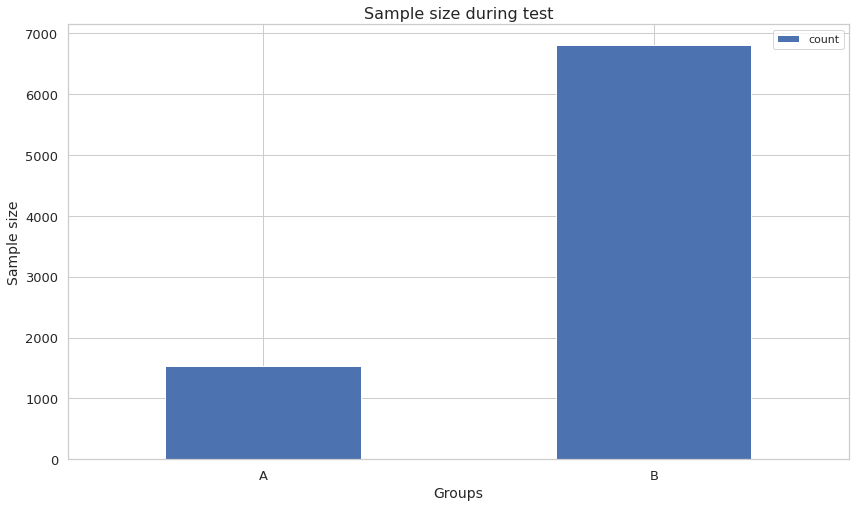

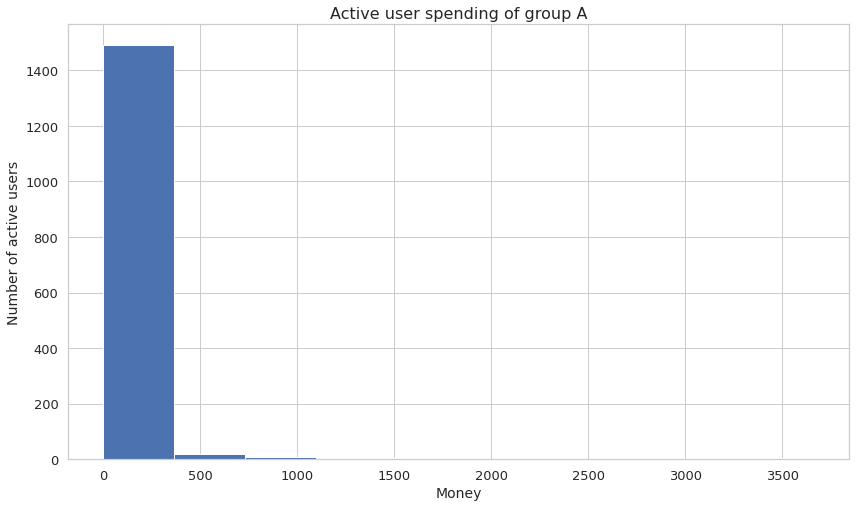

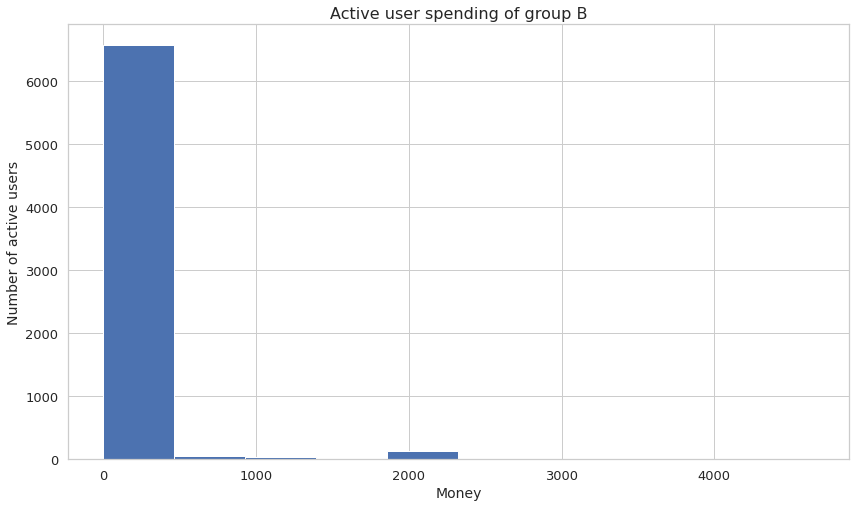

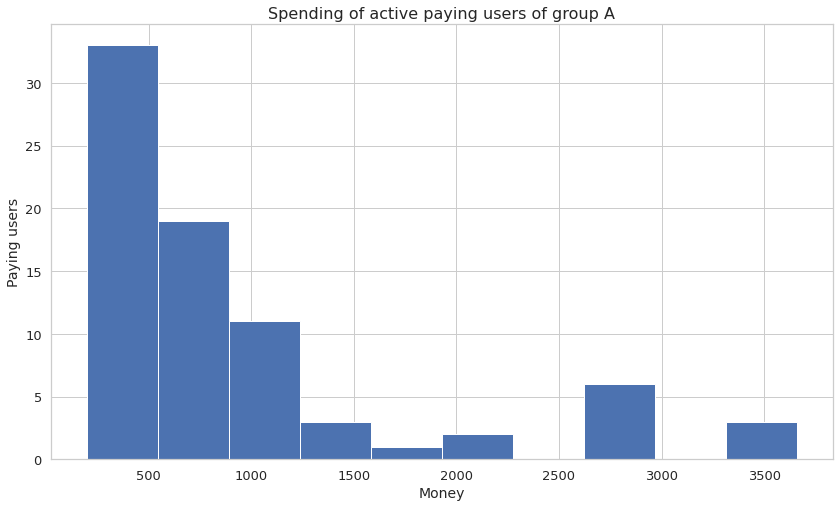

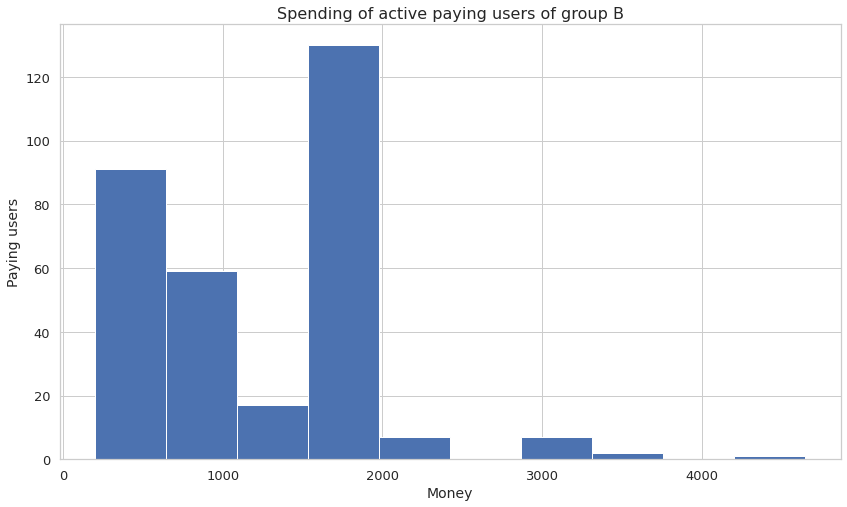

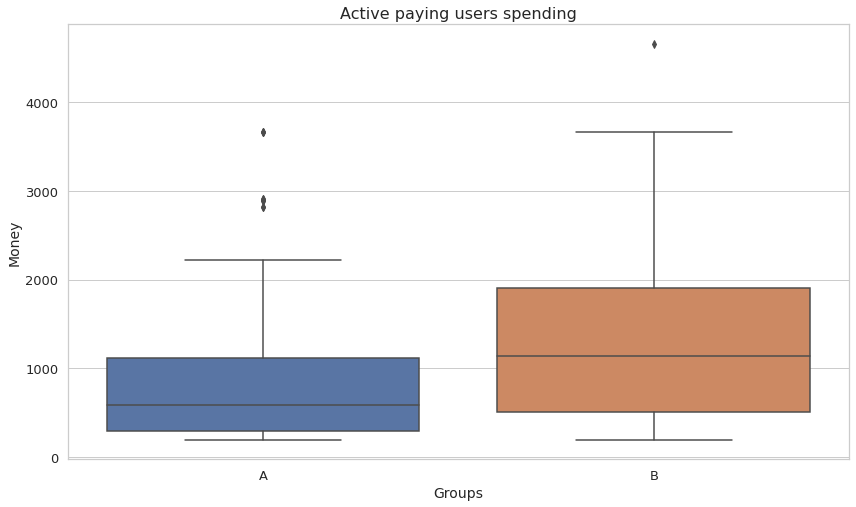

In [139]:
charts('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')